In [ ]:
pip install -U pymc3-ext exoplanet corner

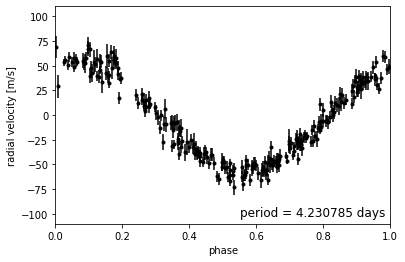

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Download the dataset from the Exoplanet Archive:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array(
    [
        l.split()
        for l in r.text.splitlines()
        if not l.startswith("\\") and not l.startswith("|")
    ],
    dtype=float,
)
t, rv, rv_err = data.T
t -= np.mean(t)

lit_period = 4.230785
plt.errorbar(
    (t % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")


In [ ]:
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

import exoplanet as xo

with pm.Model() as model:

    # Parameters
    logK = pm.Uniform(
        "logK",
        lower=0,
        upper=np.log(200),
        testval=np.log(0.5 * (np.max(rv) - np.min(rv))),
    )
    logP = pm.Uniform(
        "logP", lower=0, upper=np.log(10), testval=np.log(lit_period)
    )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)

    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    hk = pmx.UnitDisk("hk", testval=np.array([0.01, 0.01]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    # Condition on the observations
    pm.Normal("obs", mu=rvmodel, sd=rv_err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )

In [ ]:
with model:
    map_params = pmx.optimize()

optimizing logp for variables: [rvtrend, rv0, hk, phi, logP, logK]


message: Desired error not necessarily achieved due to precision loss.
logp: -1962.191778839523 -> -850.9360446619891


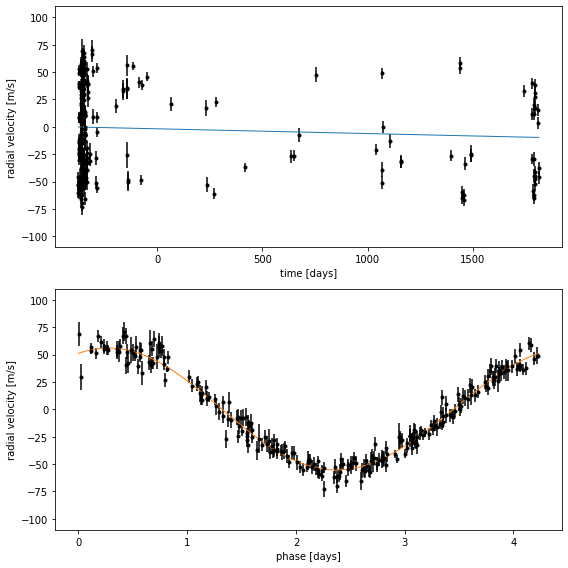

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.plot(t, map_params["bkg"], color="C0", lw=1)
ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

plt.tight_layout()

In [ ]:
with model:
    trace = pmx.sample(
        draws=1000,
        tune=1000,
        start=map_params,
        chains=2,
        cores=2,
        target_accept=0.95,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rvtrend, rv0, hk, phi, logP, logK]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.


In [ ]:
az.summary(
    trace,
    var_names=["logK", "logP", "phi", "e", "w", "rv0", "rvtrend"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logK,4.019,0.009,4.001,4.037,0.000,0.000,2154.0,1321.0,1.0
logP,1.442,0.000,1.442,1.442,0.000,0.000,2316.0,1723.0,1.0
phi,0.397,0.010,0.379,0.415,0.000,0.000,2002.0,1450.0,1.0
e,0.011,0.008,0.000,0.024,0.000,0.000,1863.0,1683.0,1.0
w,0.608,1.337,-2.228,2.983,0.036,0.025,1516.0,1520.0,1.0
rv0,-1.816,0.385,-2.533,-1.102,0.009,0.006,1913.0,1510.0,1.0
rvtrend,-1.591,0.187,-1.954,-1.269,0.004,0.003,2019.0,1452.0,1.0


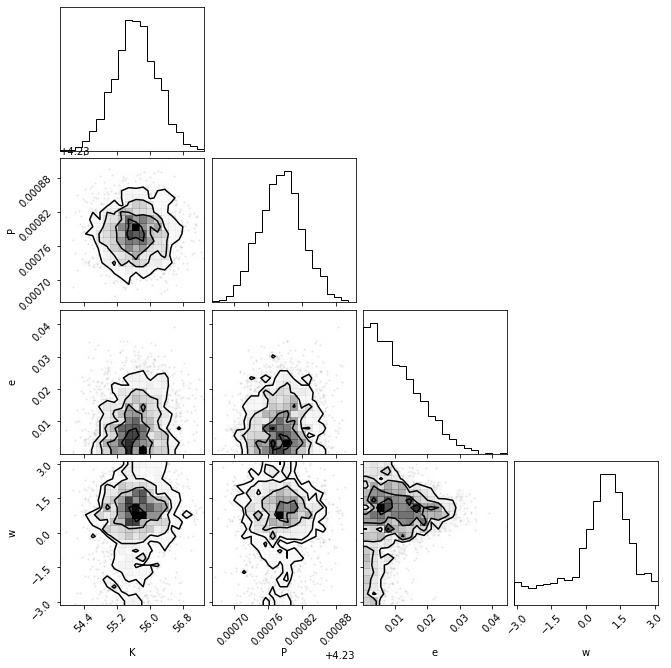

In [ ]:
_ = corner.corner(trace, var_names=["K", "P", "e", "w"])

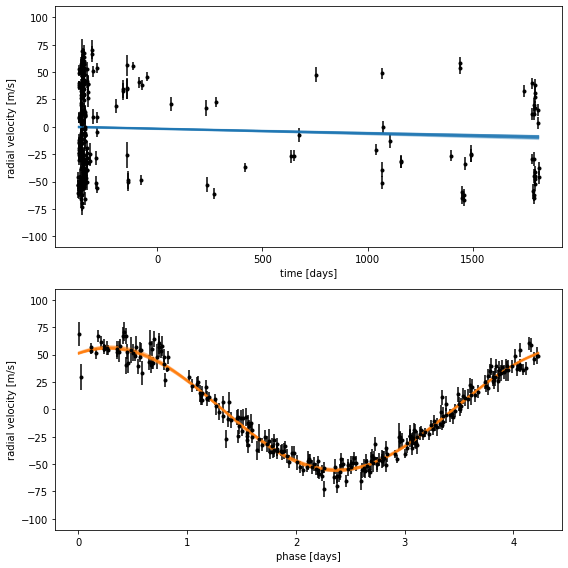

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

bkg = trace.posterior["bkg"].values
rvphase = trace.posterior["rvphase"].values

for ind in np.random.randint(np.prod(bkg.shape[:2]), size=25):
    i = np.unravel_index(ind, bkg.shape[:2])
    axes[0].plot(t, bkg[i], color="C0", lw=1, alpha=0.3)
    axes[1].plot(phase * period, rvphase[i], color="C1", lw=1, alpha=0.3)

axes[0].set_ylim(-110, 110)
axes[1].set_ylim(-110, 110)

plt.tight_layout()